# Курс "Рекомендательные системы и информационный поиск"
# AI Masters

План семинара

- считываем данные (ozon_fresh)
- график топ популярных, popularity bias
- пишем метод базовые методы (на заказах)
- сравниваем реализации метрик

In [64]:
import polars as pl
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

In [65]:
product_info = pl.read_parquet('product_information_full')
product_info

product_id,name,brand,type,category_id,category_name
i64,str,str,str,i32,str
160839072,"""CeraVe Смягчающий крем для сух…","""CeraVe""","""Гель для ухода за кожей""",38,"""Сыворотки для лица"""
161689127,"""Yves Rocher / Ив Роше / Увлажн…","""Yves Rocher France""","""Гель для ухода за кожей""",38,"""Сыворотки для лица"""
221508445,"""Bioderma Эликсир для ухода за …","""Bioderma""","""Эликсир для ухода за кожей""",38,"""Сыворотки для лица"""
309017861,"""ART&FACT. / Сыворотка для лица…","""ART&FACT.""","""Сыворотка для лица""",38,"""Сыворотки для лица"""
793710195,"""Breylee Сыворотка для лица Ант…","""Breylee""","""Сыворотка для лица""",38,"""Сыворотки для лица"""
…,…,…,…,…,…
1154315599,"""Сушилка для овощей и фруктов 3…","""Великие реки""","""Дегидратор""",284,"""Сушилки для овощей"""
1196912369,"""GFGRIL Электрическая сушилка д…","""GFGRIL""","""Дегидратор""",284,"""Сушилки для овощей"""
1255681315,"""Дегидратор сушилка для овощей …","""Marta""","""Дегидратор""",284,"""Сушилки для овощей"""


In [66]:
user_actions_sample = pl.read_parquet('user_actions_full_sample_1_000_000')
user_actions_sample

user_id,timestamp,action_type,widget_name,search_query,product_id,page_product_id
i32,datetime[ns],str,str,str,f64,f64
5191333,2024-03-20 11:04:06,"""view""","""search_catalog_listing""",null,9.23442542e8,null
3741045,2024-06-27 18:39:09,"""view""","""search_catalog_listing""","""печенье""",6.18168589e8,null
5736030,2024-03-08 14:50:14,"""view""","""search_catalog_listing""",null,1.2156e9,null
2173455,2024-04-03 12:57:27,"""view""","""recoms_fresh_personal""",null,1.46227155e8,null
9569113,2024-07-26 01:49:36,"""view""","""search_catalog_listing""",null,1.0800e9,null
…,…,…,…,…,…,…
3795880,2024-04-09 18:01:25,"""view""","""recoms_fresh_personal""",null,5.01074615e8,null
6916747,2024-04-26 14:46:01,"""view""","""search_catalog_listing""",null,1.43294378e8,null
2346229,2024-06-28 17:16:12,"""view""","""recoms_fresh_personal""",null,4.28674301e8,null


In [67]:
(
    user_actions_sample
    .group_by('action_type')
    .len()
    .sort('len', descending=True)
)

action_type,len
str,u32
"""view""",952219
"""to_cart""",14551
"""search""",14079
"""click""",12165
"""order""",6241
"""favorite""",745


Возьмем только заказы, релевантные товары - заказы из test
![image](./ts.png)

In [68]:
train = pl.read_parquet('train_orders')
test = pl.read_parquet('test_orders')

In [69]:
train

user_id,product_id,date
i32,i64,date
2569829,25343359,2024-06-05
10498283,171803041,2024-06-02
8368519,933027806,2024-06-21
10691321,679778603,2024-06-27
2062459,263792927,2024-06-28
…,…,…
1501782,1525488861,2024-05-27
6411636,167191284,2024-03-24
4407027,148234002,2024-04-19


In [70]:
train.shape, test.shape

((21982461, 3), (9324453, 3))

In [71]:
train.select('user_id').unique().count(), train.select('product_id').unique().count()

(shape: (1, 1)
 ┌─────────┐
 │ user_id │
 │ ---     │
 │ u32     │
 ╞═════════╡
 │ 1037117 │
 └─────────┘,
 shape: (1, 1)
 ┌────────────┐
 │ product_id │
 │ ---        │
 │ u32        │
 ╞════════════╡
 │ 59906      │
 └────────────┘)

In [72]:
test.select('user_id').unique().count(), test.select('product_id').unique().count()

(shape: (1, 1)
 ┌─────────┐
 │ user_id │
 │ ---     │
 │ u32     │
 ╞═════════╡
 │ 647575  │
 └─────────┘,
 shape: (1, 1)
 ┌────────────┐
 │ product_id │
 │ ---        │
 │ u32        │
 ╞════════════╡
 │ 40711      │
 └────────────┘)

In [73]:
(
    train
    .group_by('product_id')
    .len()
    .sort('len', descending=True)
)

product_id,len
i64,u32
519413018,2332887
148481523,138685
356292677,73544
398644623,69266
143259875,68298
…,…
308385693,1
166408053,1
270705313,1


что за товар 519413018? https://www.ozon.ru/product/519413018/

In [12]:
product_info.filter(pl.col('product_id') == 519413018)

product_id,name,brand,type,category_id,category_name
i64,str,str,str,i32,str
519413018,"""Пакет-майка OZON fresh""","""Нет бренда""","""Пакет майка""",553,"""Коробки и товары для хранения"""


In [74]:
def get_ozon_link(ids):
    for el in ids:
        print(f'https://www.ozon.ru/product/{el}')

In [75]:
get_ozon_link([519413018, 148481523, 356292677, 398644623])

https://www.ozon.ru/product/519413018
https://www.ozon.ru/product/148481523
https://www.ozon.ru/product/356292677
https://www.ozon.ru/product/398644623


In [76]:
train = (
    train
    .filter(pl.col('product_id') != 519413018)
)
test = (
    test
    .filter(pl.col('product_id') != 519413018)
)

История заказов

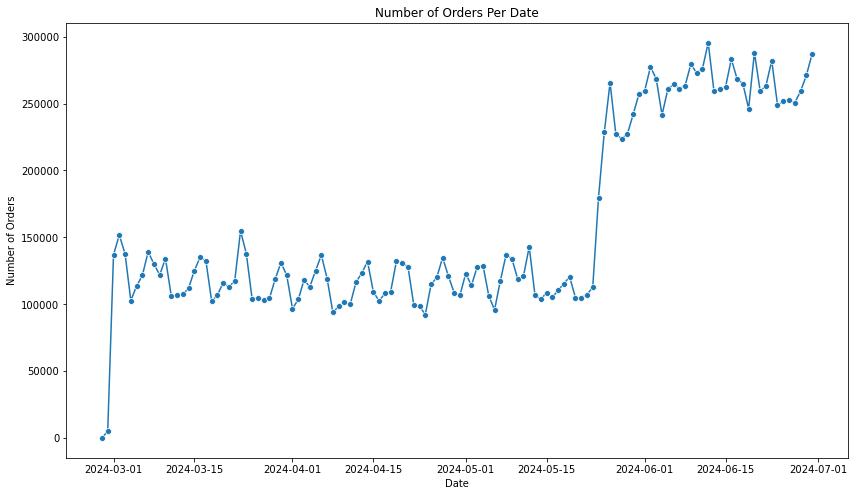

In [77]:
orders_history = (
    train
    .group_by('date')
    .len()
    .sort('date')
).to_pandas()

plt.figure(figsize=(14, 8))
sns.lineplot(x="date", y="len", data=orders_history, marker="o")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.title("Number of Orders Per Date")
plt.show()

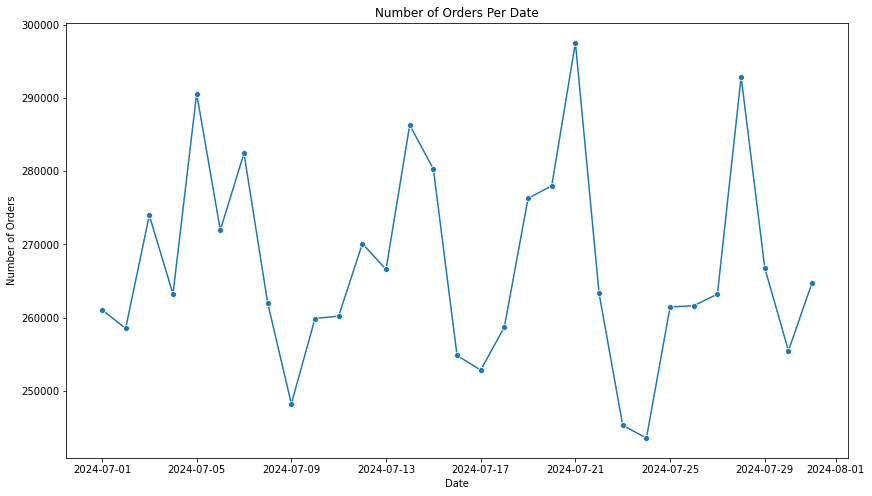

In [78]:
orders_history = (
    test
    .group_by('date')
    .len()
    .sort('date')
).to_pandas()

plt.figure(figsize=(14, 8))
sns.lineplot(x="date", y="len", data=orders_history, marker="o")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.title("Number of Orders Per Date")
plt.show()

Популярность товаров

In [79]:
(
    train
    .group_by('product_id')
    .len()
    .sort('len', descending=True)
)

product_id,len
i64,u32
148481523,138685
356292677,73544
398644623,69266
143259875,68298
146215073,63039
…,…
679896314,1
1440365637,1
378422865,1


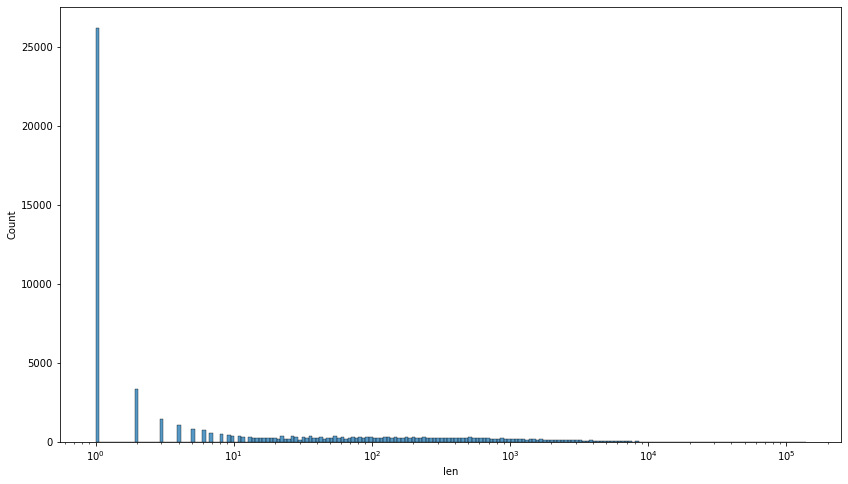

In [80]:
counts = (
    train
    .group_by('product_id')
    .len()
#     .sort('len', descending=True)
    .select('len')
).to_pandas()

plt.figure(figsize=(14, 8))
sns.histplot(counts, x='len', bins=200, log_scale=True)
plt.show()

![image](./bb.png)

Как можем рекомендовать?

- популярные товары со всего ozon fresh
- рандомные
- персональные популярные

Минусы подходов?

- ...

Попробуй реализовать в концепции fit/predict

- в fit готовим данные
- predict делаем top_k рекомендаций для пользователя

In [81]:
from typing import List

DEFAULT_USER = 0
DEFAULT_TOP_K = 10

class TopPopular:
    def __init__(self):
        self.sort_data = None
        self.id_name = None
    
    def fit(self, data: pl.DataFrame, id_name: str = 'product_id'):
        self.sort_data = (
            data
            .group_by(id_name)
            .len()
            .sort('len', descending=True)
        )
        self.id_name = id_name
        
    def predict(self, user_id: int = DEFAULT_USER, top_k: int = DEFAULT_TOP_K) -> List[int]:
        return self.sort_data.limit(top_k)[self.id_name].to_list()
        

In [83]:
tp = TopPopular()
tp.fit(train)

ids = tp.predict()
print(ids)
get_ozon_link(ids)

[148481523, 356292677, 398644623, 143259875, 146215073, 135653559, 576985723, 142120588, 266528732, 398644622]
https://www.ozon.ru/product/148481523
https://www.ozon.ru/product/356292677
https://www.ozon.ru/product/398644623
https://www.ozon.ru/product/143259875
https://www.ozon.ru/product/146215073
https://www.ozon.ru/product/135653559
https://www.ozon.ru/product/576985723
https://www.ozon.ru/product/142120588
https://www.ozon.ru/product/266528732
https://www.ozon.ru/product/398644622


In [84]:
class Random:
    def __init__(self, is_uniform: bool = True, seed: int = 0):
        self.seed = seed
        self.is_uniform = is_uniform
        self.all_ids = None
        self.p = None
    
    def fit(self, data: pl.DataFrame, id_name: str = 'product_id'):
        self.all_ids = data[id_name].unique().to_list()
        if self.is_uniform:
            self.p = [1 / len(self.all_ids)] * len(self.all_ids)
        else:
            self.p = (
                data
                .group_by(id_name)
                .len()
                .with_columns(
                    (pl.col('len') / data.shape[0]).alias('p'),
                )
            )['p'].to_list()
        
    def predict(
        self,
        user_id: int = DEFAULT_USER,
        top_k: int = DEFAULT_TOP_K,
        seed_per_user: bool = True
    ) -> List[int]:
        seed = self.seed
        if seed_per_user:
            seed += user_id
        np.random.seed(seed)
        return np.random.choice(self.all_ids, size=top_k, replace=False, p=self.p)
        

In [85]:
rn = Random()
rn.fit(train)

ids = rn.predict()
print(ids)
get_ozon_link(ids)

[1052317042 1419291397 1190943142 1045731860  796484756 1281092044
  822275379 1573135199 1598431153  702114303]
https://www.ozon.ru/product/1052317042
https://www.ozon.ru/product/1419291397
https://www.ozon.ru/product/1190943142
https://www.ozon.ru/product/1045731860
https://www.ozon.ru/product/796484756
https://www.ozon.ru/product/1281092044
https://www.ozon.ru/product/822275379
https://www.ozon.ru/product/1573135199
https://www.ozon.ru/product/1598431153
https://www.ozon.ru/product/702114303


In [86]:
ids = rn.predict(user_id=1000, top_k=5)
print(ids)
get_ozon_link(ids)

[1299961148  162882299 1592776656  893851473 1567883537]
https://www.ozon.ru/product/1299961148
https://www.ozon.ru/product/162882299
https://www.ozon.ru/product/1592776656
https://www.ozon.ru/product/893851473
https://www.ozon.ru/product/1567883537


In [87]:
ids = rn.predict(user_id=1001, top_k=5)
print(ids)
get_ozon_link(ids)

[519820506 397657378 261940704 811320729 136780558]
https://www.ozon.ru/product/519820506
https://www.ozon.ru/product/397657378
https://www.ozon.ru/product/261940704
https://www.ozon.ru/product/811320729
https://www.ozon.ru/product/136780558


In [88]:
rn = Random(is_uniform=False)
rn.fit(train)

In [89]:
ids = rn.predict(user_id=1000, top_k=5)
print(ids)
get_ozon_link(ids)

[1289702410  160500158 1587708061  871762853 1566410422]
https://www.ozon.ru/product/1289702410
https://www.ozon.ru/product/160500158
https://www.ozon.ru/product/1587708061
https://www.ozon.ru/product/871762853
https://www.ozon.ru/product/1566410422


In [90]:
ids = rn.predict(user_id=1001, top_k=5)
print(ids)
get_ozon_link(ids)

[521504101 397204801 241611101 788075551 135507662]
https://www.ozon.ru/product/521504101
https://www.ozon.ru/product/397204801
https://www.ozon.ru/product/241611101
https://www.ozon.ru/product/788075551
https://www.ozon.ru/product/135507662


In [91]:
class PersonalTopPopular:
    def __init__(self):
        self.sort_data = None
        self.id_name = None
        self.user_id = None
    
    def fit(self, data: pl.DataFrame, id_name: str = 'product_id', user_id: str = 'user_id'):
        self.sort_data = (
            data
            .group_by(user_id, id_name)
            .len()
            .sort('len', descending=True)
        )
        self.id_name = id_name
        self.user_id = user_id
        
    def predict(self, user_id: int = DEFAULT_USER, top_k: int = DEFAULT_TOP_K) -> List[int]:
        return (
            self.sort_data
            .filter(pl.col(self.user_id) == user_id)
            .limit(top_k)[self.id_name]
        ).to_list()

In [92]:
# %%timeit
ptp = PersonalTopPopular()
ptp.fit(train)

In [93]:
ptp = PersonalTopPopular()
ptp.fit(train)

ids = ptp.predict()
print(ids)
get_ozon_link(ids)

[]


In [94]:
ids = ptp.predict(user_id=10498283, top_k=5)
print(ids)
get_ozon_link(ids)

[862361533, 171803041, 141735019, 149724901, 149262631]
https://www.ozon.ru/product/862361533
https://www.ozon.ru/product/171803041
https://www.ozon.ru/product/141735019
https://www.ozon.ru/product/149724901
https://www.ozon.ru/product/149262631


Рекомендовать научились (чуть-чуть), теперь к метрикам!

In [95]:
sample_users = (
    test
    .group_by('user_id')
    .agg(
        pl.col("product_id").unique().alias("ids")
    )
    .sample(n=1000, seed=0)
)

In [96]:
sample_users

user_id,ids
i32,list[i64]
4360681,"[216966670, 325364626, … 1525488861]"
1342180,"[568665879, 623810806]"
9499839,"[292164342, 293340952]"
6113365,"[138235079, 164861610, … 1556009842]"
10368933,"[7353497, 33006450, … 1621485697]"
…,…
10278248,"[137825742, 138235079, … 1394654878]"
2566186,"[143460206, 267409068, 870147515]"
4646645,[762657205]


In [97]:
tp = TopPopular()
tp.fit(train)

rn_uniform = Random(is_uniform=True)
rn_uniform.fit(train)

rn = Random(is_uniform=False)
rn.fit(train)

ptp = PersonalTopPopular()
ptp.fit(train)

In [98]:
recommemd_sample_users = (
    sample_users
    .with_columns([
        pl.col('user_id').map_elements(
            lambda x: tp.predict(user_id=x, top_k=10),
            return_dtype=pl.List(pl.Int64)
        ).alias('tp_recs'),
        
        pl.col('user_id').map_elements(
            lambda x: rn_uniform.predict(user_id=x, top_k=10),
            return_dtype=pl.List(pl.Int64)
        ).alias('rn_uniform_recs'),
        
        pl.col('user_id').map_elements(
            lambda x: rn.predict(user_id=x, top_k=10),
            return_dtype=pl.List(pl.Int64)
        ).alias('rn_recs'),
        
        pl.col('user_id').map_elements(
            lambda x: ptp.predict(user_id=x, top_k=10),
            return_dtype=pl.List(pl.Int64)
        ).alias('ptp_recs'),
    ])
)
recommemd_sample_users

user_id,ids,tp_recs,rn_uniform_recs,rn_recs,ptp_recs
i32,list[i64],list[i64],list[i64],list[i64],list[i64]
4360681,"[216966670, 325364626, … 1525488861]","[148481523, 356292677, … 398644622]","[1605913042, 304653912, … 137834842]","[551318697, 142822572, … 719370152]",[]
1342180,"[568665879, 623810806]","[148481523, 356292677, … 398644622]","[175650177, 33497920, … 1410424408]","[336265664, 839697616, … 1451235848]",[]
9499839,"[292164342, 293340952]","[148481523, 356292677, … 398644622]","[769186167, 817924358, … 635849884]","[169383511, 34565015, … 1410780654]","[808880421, 293340952, … 1004303952]"
6113365,"[138235079, 164861610, … 1556009842]","[148481523, 356292677, … 398644622]","[659840427, 1074808936, … 262213675]","[1595851593, 1244983540, … 1477461231]",[]
10368933,"[7353497, 33006450, … 1621485697]","[148481523, 356292677, … 398644622]","[1133570299, 1004744029, … 314840146]","[1555211050, 1583522904, … 1210954897]","[315272234, 145803938, … 1394229036]"
…,…,…,…,…,…
10278248,"[137825742, 138235079, … 1394654878]","[148481523, 356292677, … 398644622]","[1187578532, 1443873616, … 1567761763]","[148170424, 1527245529, … 1234446044]",[135965145]
2566186,"[143460206, 267409068, 870147515]","[148481523, 356292677, … 398644622]","[172392088, 1553797623, … 154156600]","[167300840, 1547383254, … 150030863]","[138364818, 783409891, 881668528]"
4646645,[762657205],"[148481523, 356292677, … 398644622]","[230999864, 636912764, … 272099808]","[688373859, 1427182289, … 306461038]",[]


https://www.evidentlyai.com/ranking-metrics/precision-recall-at-k

In [99]:
# recall precision
def calc_pr_metrics(data, recs_column):
    metrics = (
        data
        .select('user_id', 'ids', recs_column)
        .with_columns([
            pl.col('ids').list.set_intersection(pl.col(recs_column)).alias(f'relevant_in_{recs_column}')
        ])
        .with_columns([
            pl.col(f'relevant_in_{recs_column}').list.len().alias('len1'),
            pl.col(recs_column).list.len().alias('len2'),
            pl.col('ids').list.len().alias('len3'),
        ])
        .with_columns([
            (pl.col('len1') / pl.col('len3')).alias('recall'),
            (pl.col('len1') / pl.col('len2')).alias('precision'),
        ])
        .fill_nan(0)
        .select(
            pl.mean('recall').alias('recall'),
            pl.mean('precision').alias('precision'),
        )
    )
    return metrics

In [100]:
calc_pr_metrics(recommemd_sample_users, 'tp_recs')

recall,precision
f64,f64
0.029331,0.0343


In [101]:
calc_pr_metrics(recommemd_sample_users, 'rn_uniform_recs')

recall,precision
f64,f64
0.000146,0.0002


In [102]:
calc_pr_metrics(recommemd_sample_users, 'rn_recs')

recall,precision
f64,f64
0.000077,0.0001


In [103]:
calc_pr_metrics(recommemd_sample_users, 'ptp_recs')

recall,precision
f64,f64
0.084717,0.126536


https://github.com/MobileTeleSystems/RecTools

In [104]:
from rectools.metrics import (
    Precision,
    NDCG,
    Recall,
    MAP,
)

recall = Recall(k=10)
precision = Precision(k=10)

In [105]:
interactions = (
    recommemd_sample_users
    .select('user_id', pl.col('ids').alias('item_id'))
    .explode('item_id')
).to_pandas()
reco = (
    recommemd_sample_users
    .select('user_id', pl.col('ptp_recs').alias('item_id'), pl.lit(1).alias('rank'))
    .explode('item_id')
).to_pandas()

In [106]:
print(
    'recall: ', recall.calc(reco=reco, interactions=interactions),
    'precision: ', precision.calc(reco=reco, interactions=interactions)
)

recall:  0.08471680281378315 precision:  0.09609999999999999


In [107]:
calc_pr_metrics(recommemd_sample_users, 'ptp_recs')

recall,precision
f64,f64
0.084717,0.126536


можем почитать такой пост https://t.me/datarascals/66 <br>
в precision делим на k или на кол-во рекомендаций?

In [108]:
# recall precision
def calc_pr_metrics_v2(data, recs_column, top_k: int = DEFAULT_TOP_K):
    metrics = (
        data
        .select('user_id', 'ids', recs_column)
        .with_columns([
            pl.col('ids').list.set_intersection(pl.col(recs_column)).alias(f'relevant_in_{recs_column}')
        ])
        .with_columns([
            pl.col(f'relevant_in_{recs_column}').list.len().alias('len1'),
            pl.col(recs_column).list.len().alias('len2'),
            pl.col('ids').list.len().alias('len3')
        ])
        .with_columns([
            (pl.col('len1') / pl.col('len3')).alias('recall'),
            (pl.col('len1') / top_k).alias('precision'),
        ])
        .fill_nan(0)
        .select(
            pl.mean('recall').alias('recall'),
            pl.mean('precision').alias('precision')
        )
    )
    return metrics

In [109]:
calc_pr_metrics_v2(recommemd_sample_users, 'ptp_recs')

recall,precision
f64,f64
0.084717,0.0961


In [110]:
print(
    'recall: ', recall.calc(reco=reco, interactions=interactions),
    'precision: ', precision.calc(reco=reco, interactions=interactions)
)

recall:  0.08471680281378315 precision:  0.09609999999999999


In [111]:
ndcg = NDCG(k=10)
map10 = MAP(k=10)

In [112]:
print(
    'map10: ', map10.calc(reco=reco, interactions=interactions),
    'ndcg: ', ndcg.calc(reco=reco, interactions=interactions),
)

map10:  0.08471680281378315 ndcg:  0.21150818741245508


реализации метрик
- rectools https://github.com/MobileTeleSystems/RecTools
- replay https://github.com/sberbank-ai-lab/RePlay
- реализация для torch https://github.com/zuoxingdong/recsys_metrics
- evidently https://docs.evidentlyai.com/metrics/explainer_recsys https://github.com/evidentlyai/evidently/tree/main/src/evidently/metrics/recsys
- catboost https://catboost.ai/docs/en/concepts/loss-functions-ranking
- даже в sklearn есть https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ndcg_score.html
- ручная реализация на вашей работе :)

Еще раз посмотрим на наши рекомендации

In [113]:
recommemd_sample_users

user_id,ids,tp_recs,rn_uniform_recs,rn_recs,ptp_recs
i32,list[i64],list[i64],list[i64],list[i64],list[i64]
4360681,"[216966670, 325364626, … 1525488861]","[148481523, 356292677, … 398644622]","[1605913042, 304653912, … 137834842]","[551318697, 142822572, … 719370152]",[]
1342180,"[568665879, 623810806]","[148481523, 356292677, … 398644622]","[175650177, 33497920, … 1410424408]","[336265664, 839697616, … 1451235848]",[]
9499839,"[292164342, 293340952]","[148481523, 356292677, … 398644622]","[769186167, 817924358, … 635849884]","[169383511, 34565015, … 1410780654]","[808880421, 293340952, … 1004303952]"
6113365,"[138235079, 164861610, … 1556009842]","[148481523, 356292677, … 398644622]","[659840427, 1074808936, … 262213675]","[1595851593, 1244983540, … 1477461231]",[]
10368933,"[7353497, 33006450, … 1621485697]","[148481523, 356292677, … 398644622]","[1133570299, 1004744029, … 314840146]","[1555211050, 1583522904, … 1210954897]","[315272234, 145803938, … 1394229036]"
…,…,…,…,…,…
10278248,"[137825742, 138235079, … 1394654878]","[148481523, 356292677, … 398644622]","[1187578532, 1443873616, … 1567761763]","[148170424, 1527245529, … 1234446044]",[135965145]
2566186,"[143460206, 267409068, 870147515]","[148481523, 356292677, … 398644622]","[172392088, 1553797623, … 154156600]","[167300840, 1547383254, … 150030863]","[138364818, 783409891, 881668528]"
4646645,[762657205],"[148481523, 356292677, … 398644622]","[230999864, 636912764, … 272099808]","[688373859, 1427182289, … 306461038]",[]


Как можем быстро улучшить personal top?

In [114]:
class PersonalTopPopularV2:
    def __init__(self, top_popular, personal_top_popular):
        self.top_popular = top_popular
        self.personal_top_popular = personal_top_popular
    
    def fit(self, data: pl.DataFrame, id_name: str = 'product_id', user_id: str = 'user_id'):
        self.top_popular.fit(data, id_name)
        self.personal_top_popular.fit(data, id_name, user_id)
        
    def predict(self, user_id: int = DEFAULT_USER, top_k: int = DEFAULT_TOP_K) -> List[int]:
        recs = []
        pers_top = self.personal_top_popular.predict(user_id, top_k)
        if len(pers_top) < top_k:
            top = self.top_popular.predict(user_id, top_k - len(pers_top))
            recs = pers_top + top
        else:
            recs = pers_top
        return recs

In [115]:
ptp = PersonalTopPopular()
ptp.fit(train)

In [116]:
ptp_v2 = PersonalTopPopularV2(top_popular=tp, personal_top_popular=ptp)
ptp_v2.fit(train)

In [117]:
recommend_sample_users = (
    sample_users
    .with_columns([
        pl.col('user_id').map_elements(
            lambda x: ptp.predict(user_id=x, top_k=10),
            return_dtype=pl.List(pl.Int64)
        ).alias('ptp_recs'),
        pl.col('user_id').map_elements(
            lambda x: ptp_v2.predict(user_id=x, top_k=10),
            return_dtype=pl.List(pl.Int64)
        ).alias('ptp_v2_recs'),
    ])
)
recommend_sample_users

user_id,ids,ptp_recs,ptp_v2_recs
i32,list[i64],list[i64],list[i64]
4360681,"[216966670, 325364626, … 1525488861]",[],"[148481523, 356292677, … 398644622]"
1342180,"[568665879, 623810806]",[],"[148481523, 356292677, … 398644622]"
9499839,"[292164342, 293340952]","[808880421, 293340952, … 1004303952]","[808880421, 293340952, … 135653559]"
6113365,"[138235079, 164861610, … 1556009842]",[],"[148481523, 356292677, … 398644622]"
10368933,"[7353497, 33006450, … 1621485697]","[1011702796, 315272234, … 484661897]","[1011702796, 315272234, … 484661897]"
…,…,…,…
10278248,"[137825742, 138235079, … 1394654878]",[135965145],"[135965145, 148481523, … 266528732]"
2566186,"[143460206, 267409068, 870147515]","[138364818, 881668528, 783409891]","[138364818, 881668528, … 576985723]"
4646645,[762657205],[],"[148481523, 356292677, … 398644622]"


In [118]:
calc_pr_metrics_v2(recommend_sample_users, 'ptp_recs')

recall,precision
f64,f64
0.081819,0.0924


In [119]:
calc_pr_metrics_v2(recommend_sample_users, 'ptp_v2_recs')

recall,precision
f64,f64
0.099676,0.1015


## Еще про данные
Популярные открытые датасеты
- MovieLens https://grouplens.org/datasets/movielens/
- Steam https://www.kaggle.com/datasets/tamber/steam-video-games/data
- Yambda https://huggingface.co/datasets/yandex/yambda
- VK-LSVD https://huggingface.co/datasets/deepvk/VK-LSVD